***Note: this is the Allosteric.ipynb notebook. The
PDF version "Allosteric inhibition as a control actuator: loop-gain analysis"
is available [here](Allosteric.pdf).***

# Introduction
Using the methods of control theory to examine and reexamine the behaviour of living systems is well-established
<cite data-cite="Cra47a">(Craik, 1947)</cite>
<cite data-cite="Wie61">(Weiner, 1961)</cite>
<cite data-cite="Bay66">(Bayliss, 1966)</cite>
<cite data-cite="Sav09">(Savageau, 1976)</cite>
<cite data-cite="JagFla03">(Jagacinski and Flach, 2003)</cite>
<cite data-cite="IglIng10">(Inglesias and Ingalls, 2010)</cite>
<cite data-cite="WelBulKalMasVer08">(Wellstead et al, 2008)</cite>
<cite data-cite="DriLeaDet15">(Drion et al, 2015)</cite>
<cite data-cite="Vec13">(Del Veccio, 2013)</cite>.
This notebook examines the enzyme-catalysed reaction as a control actuator and its behavior within a feedback loop controlling product concentration. The feedback mechanism used is *Allosteric inhibition* - see section 1.4.3
<cite data-cite="KeeSne09">(Keener and Sneyd, 2009)</cite>. 

- The notebook [fECR](https://github.com/gawthrop/BondGraphTools-Biomolecular/blob/master/fECR.ipynb) looks at an alternative feedback mechanism : feedback inhibition.
- As discussed in the sequel, feedback inhibition is a special case of allosteric inhibition.
- As discussed in the notebook [fECR](fECR.pdf), the control methodology is based on 
    [Linearisation](https://github.com/gawthrop/BondGraphTools-Biomolecular/blob/master/Linearisation.ipynb).
- This notebook introduces a novel method for deducing the *feedback loop-gain* $L(s)$ from the bond graph describing the biomolecular system. $L(s)$ is a crucial component of feedback control analysis.

## Import some python code
The bond graph analysis uses a number of Python modules:

In [1]:
## Some useful imports
import BondGraphTools as bgt
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import IPython.display as disp

## Stoichiometric analysis
import stoich as st

## SVG bg representation conversion
import svgBondGraph as sbg

## Control systems package
import control as con

## Set quiet=False for verbose output
quiet = True

## Set slycot=True if slycot is installed (see control module)
slycot=True

## For reimporting: use imp.reload(module)
import importlib as imp

## Printing options
np.set_printoptions(precision=3)
fmt = '{:5.3f}'

## Allow output from within functions
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Minreal (minimum realisation algorithm) tolerance
tol = 1e-2

## Chemostat EM and CM
chemostatEMCM = True


## Derive stoichiometry from bond graph

In [2]:
def stoichiometry(abg,chemostats=[]):
    s = st.stoich(abg.model(),quiet=quiet)
    sc = st.statify(s,chemostats=chemostats)    
    return s,sc

# Enzme catalysed reaction with allosteric inhibition

## Bond graph model

-  **Ce:A**: substrate
-  **Ce:B**: product
-  **Ce:B0**: product sink
-  **Ce:E**: enzyme
-  **Ce:C**: enzyme bound to A
-  **Ce:F** and **Ce:G**: species pumping the reaction
-  **Ce:B**: product
-  **Ce:EM**: enzyme bound to M
-  **Ce:CM**: complex C bound to M
-  Corresponding reactions are:

\begin{align}
\ch{A + E + F &<>[ r1 ] C }\\
\ch{C &<>[ r2 ] B + E + G }\\
\ch{B &<>[ r3 ] B0 }\\
\ch{CM &<>[ ra ] A + EM }\\
\ch{5 B + C &<>[ rc ] CM }\\
\ch{EM &<>[ re ] 5 B + E }
\end{align}

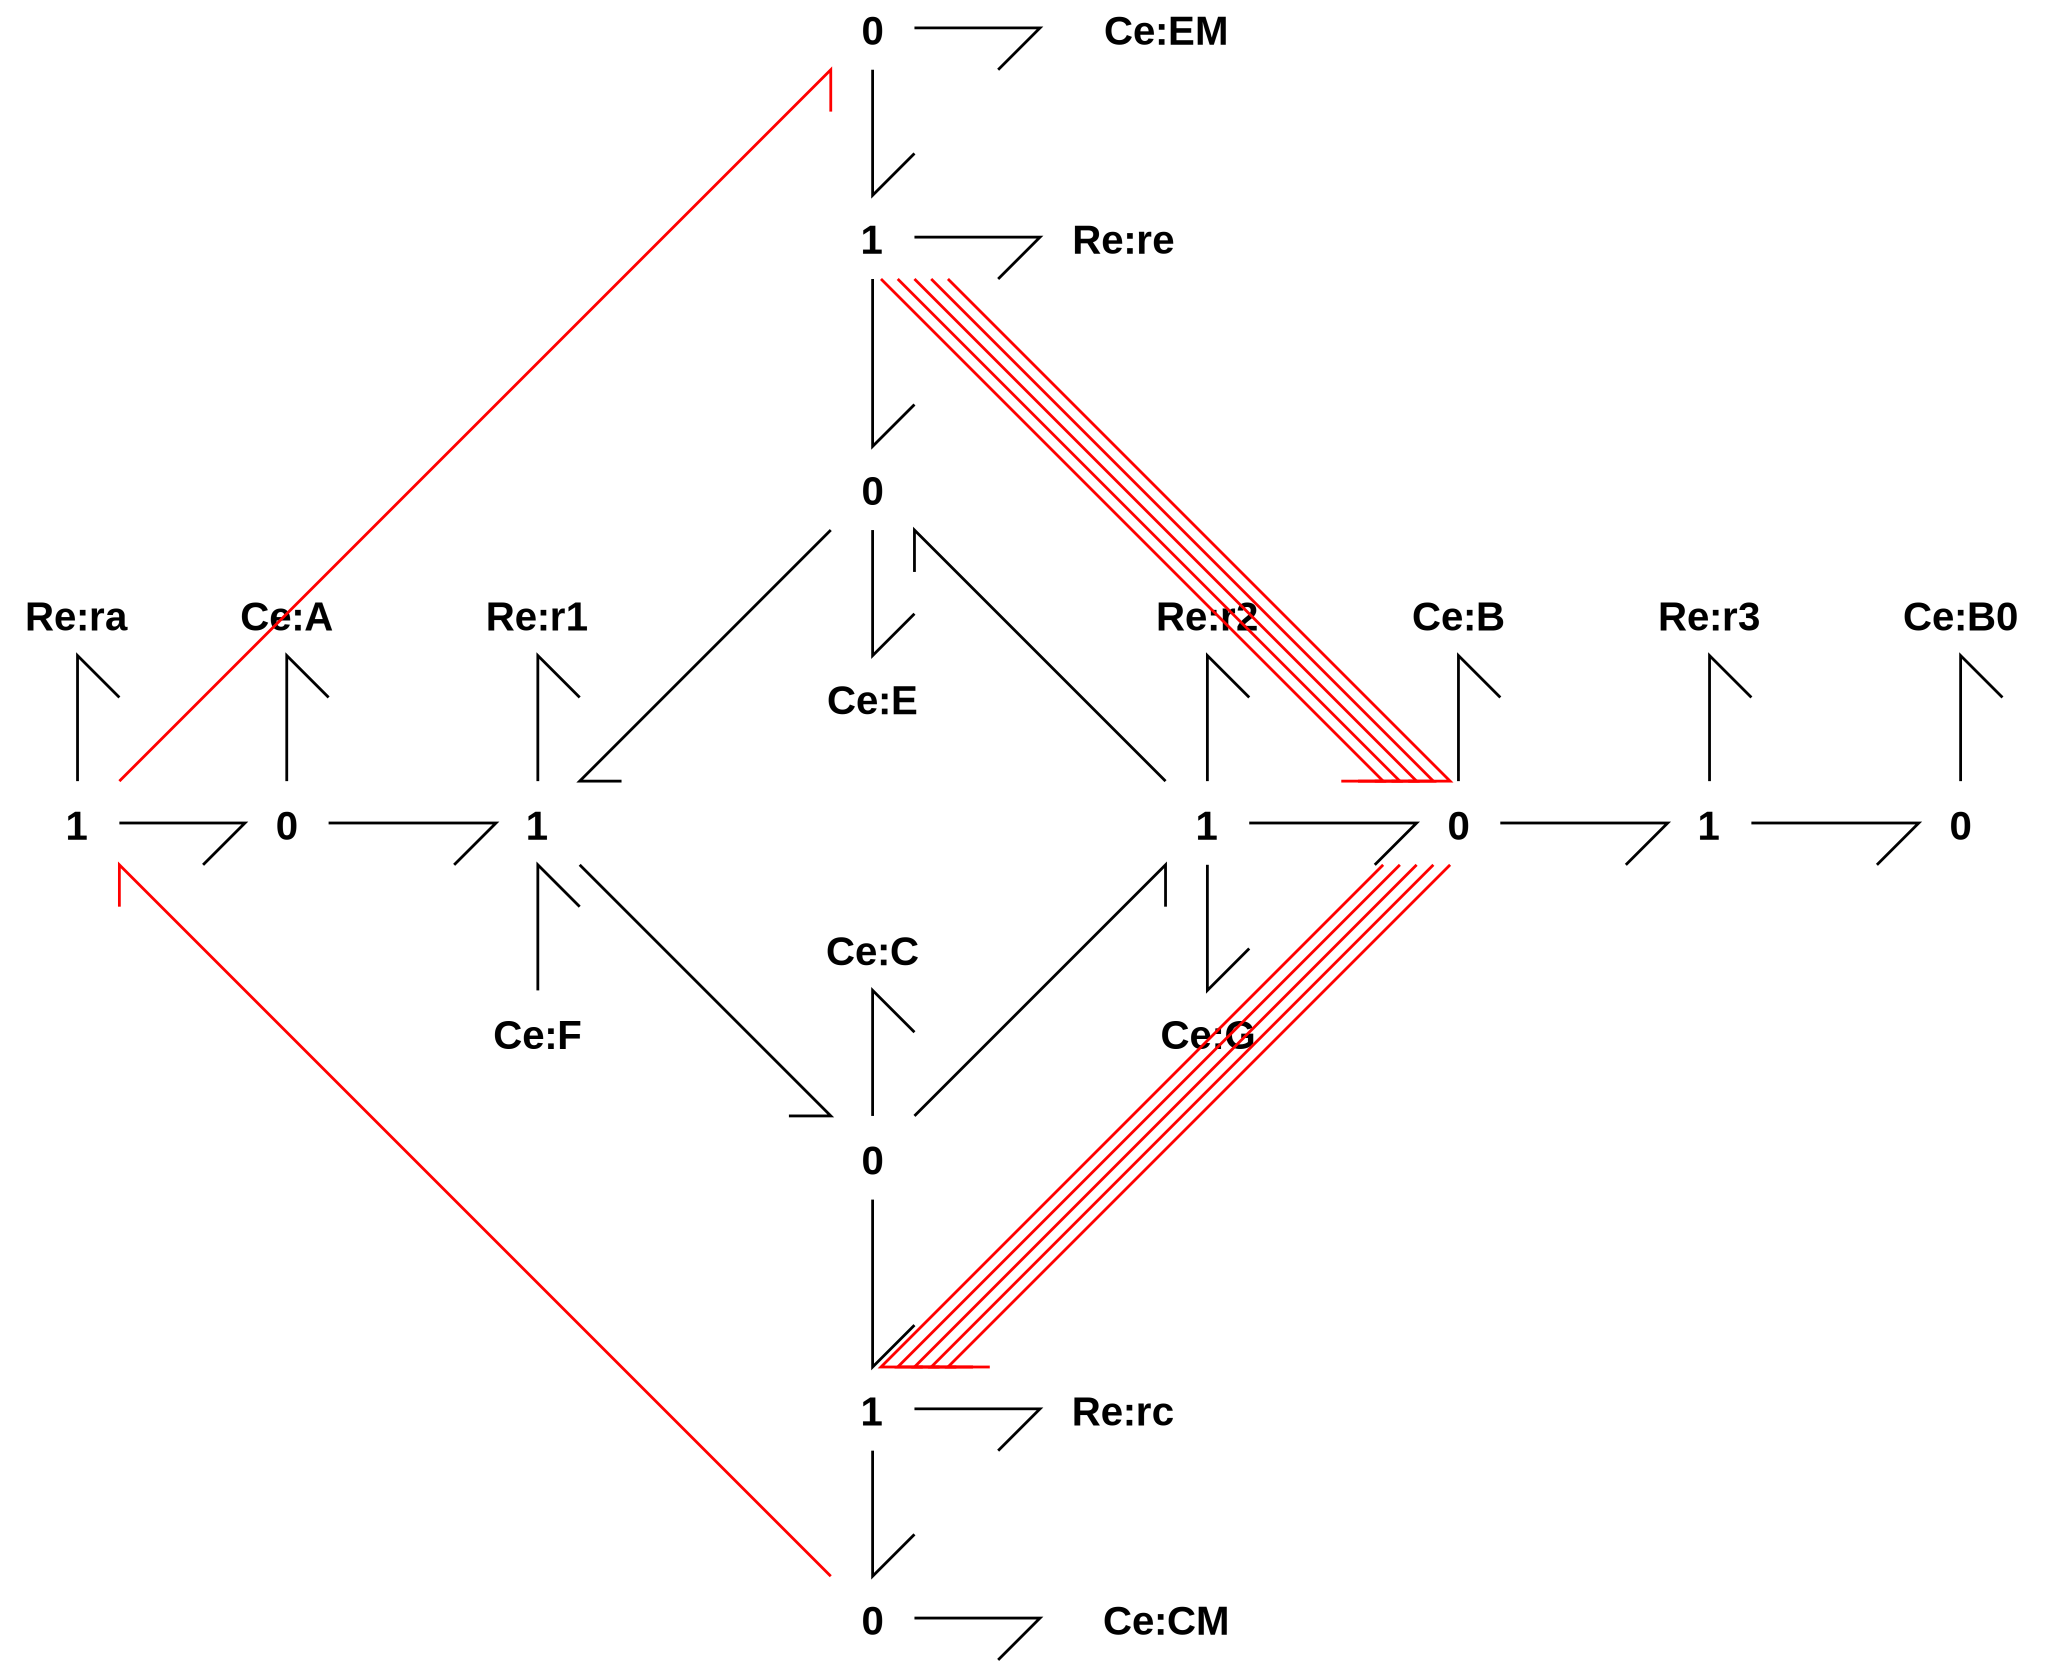

In [3]:
sbg.model('aiRE_abg.svg',quiet=quiet)
import aiRE_abg
abg = aiRE_abg
disp.SVG('aiRE_abg.svg')

In [4]:
## Stoichiometry
#chemostats=['A','B0','F','G','EM','CM']
chemostats=['A','B0','F','G']
if chemostatEMCM:
    chemostats += ['EM','CM']

s,sc = stoichiometry(abg,chemostats=chemostats)

print('Reactions:')
disp.Latex(st.sprintrl(s,chemformula=False))
sp = st.path(s,sc)

Reactions:


<IPython.core.display.Latex object>

## Numerical parameters

In [5]:
## Parameters
X0_A = 1
K_A = 1
K_B = 1
K_C = 1
K_E = 1
K_F = 1e2
K_G = 1/K_F

K_EM = 1
K_CM = 1

kappa = 1
kappa_r1 = kappa
kappa_r2 = kappa

## Open-loop
kappa_ra = 0
kappa_rc = 0
kappa_re = 0

K_B0 = 1
X0_B0 = 1e-6
kappa_r3 = 1

pars = ['X0_A','K_A','K_B','K_C','K_E','K_F','K_G',
        'K_EM','K_CM',
        'kappa_r1','kappa_r2','kappa_ra','kappa_rc','kappa_re',
        'K_B0','X0_B0','kappa_r3']
parameter = {}
for par in pars:
    parameter[par] = eval(par)

if not quiet:
    print('Parameters',parameter)

## Utility functions

In [6]:
def plotStep(tf,chemo,spec,T):
    
    t,y = con.step_response(tf,T=T)
    plt.plot(t,y)
    plt.grid()
    plt.xlabel('t')
    plt.ylabel('x_B')
    plt.title('Step response from '+chemo+' to '+spec)
    plt.show()
    
def showTF(tf):
    ## Show info
    print(tf)
    in_gain_X = con.dcgain(tf)
    print('\tgain:',fmt.format(in_gain_X))
    print('\tpoles:', con.pole(tf))
    print('\tzeros:', con.zero(tf))

def extractTF(TF,chemo,spec):
    
    ## Index of product
    species = s['species']
    i_prod = species.index(spec)
    
    ## Index of input
    i = chemostats.index(chemo)
    
    ## Extract tf
    print('\nTransfer function from','x_'+chemo,'to','x_'+spec)
    tf = con.minreal(TF[i_prod,i])
    
    showTF(tf)
    
    return tf

def extractTFflow(TF,chemo,chemostats,reac):
    
    ## Index of reaction
    reaction = s['reaction']
    i_v = reaction.index(reac)
    
    ## Index of input
    i = chemostats.index(chemo)
    
    ## Extract tf
    print('\nTransfer function from','x_'+chemo,'to','v_'+reac)
    tf = con.minreal(TF[i_v,i])
    
    showTF(tf)
    
    return tf

# Closed-loop analysis
The function **ClosedLoop** derives the closed-loop properteis of the system from the bond graph model in the following steps:

- Extract stoichiometry
- Simulate the system to give a steady state
- linearise the closed-loop system about this steady state to give:
   - the multivariable transfer function relating chemostats to species states
   - the multivariable transfer function relating chemostats to reaction flows
- extract the scalar transfer functions relating the 'disturbance' $x_{B0}$ to
    - the product state $x_B$
    - the 'actuator' flow $v_{r2}$

In [7]:
def ClosedLoop(abg,chemostats,parameter,t_step,quiet=False):
    ## Analyse the system
    
    ## Stoichiometry
    s,sc = stoichiometry(abg,chemostats=chemostats)
    
    ## Steady-state simulation
    t = np.linspace(0,1000,1000)
    ssdat = st.sim(s,sc=sc,t=t,parameter=parameter,quiet=quiet)

    ## Use the final value as the steady-state
    x_ss = ssdat['X'][-1,:]
    
    if not quiet:
        print(s['species'])
        print('x_ss =', x_ss)   
    
    ##Linearise
    SysX = st.lin(s,sc,x_ss=x_ss,parameter=parameter,outvar='X',quiet=quiet) 
    SysV = st.lin(s,sc,x_ss=x_ss,parameter=parameter,outvar='V',quiet=quiet)
    
    ## Multivariable transfer functions
    TF = con.ss2tf(SysX)
    TFV = con.ss2tf(SysV)

    ## Scalar transfer function to x_B
    tf_B0 = extractTF(TF,'B0','B')
    t,x_B = con.step_response(tf_B0,T=t_step)

    ## Scalar transfer function to v_r2
    tf_v2 = extractTFflow(TFV,'B0',chemostats,'r2')
    t,v_r2 = con.step_response(tf_v2,T=t_step)

    return x_B,v_r2,x_ss

## Open-loop system
Setting $\kappa_{re} = \kappa_{rc} = \kappa_{ra} = 0$ prevents flow through the inhibition system and thus feedback is prevented. The system is open-loop.

- the closed-loop transfer function relating $x_{B0}$ to $x_{B}$ is $\dfrac{1}{s+1}$. This has a steady-state gain of unity: the disturbance is not reduced.
- the closed-loop transfer function relating $x_{B0}$ to $x_{r2}$ is $\approx 0$. It becomes zero as $K_F \to \infty$. There is no feednack.

In [8]:
## Open loop
t_step = np.linspace(0,20,100)
print("Open loop")

parameter['kappa_re'] = 0
parameter['kappa_rc'] = 0
parameter['kappa_ra'] = 0

x_ol,v_ol,x_ss_ol = ClosedLoop(abg,chemostats,parameter,t_step,quiet=quiet)


Open loop

Transfer function from x_B0 to x_B
1 states have been removed from the model

  1
-----
s + 1

	gain: 1.000
	poles: [-1.]
	zeros: []

Transfer function from x_B0 to v_r2
0 states have been removed from the model

-0.0003921 s - 0.0396
---------------------
 s^2 + 103 s + 102.1

	gain: -0.000
	poles: [-102.02   -1.  ]
	zeros: [-101.]


## Feedback inhibition
Setting $\kappa_{rc} = \kappa_{ra} = 0$ and $\kappa_{re}=1$ restricts feedback to the path through re and is thus equivalent to feedback inhibition.

- the closed-loop transfer function relating $x_{B0}$ to $x_{B}$ has a steady-state gain of 0.167; the effect of the disturbance is reduced by feedback. 
- the closed-loop transfer function relating $x_{B0}$ to $x_{r2}$ has a steady-state gain of -0.833; this is negative feedback.

In [9]:
## Feedback inhibition
print('Feedback inhibition')

parameter['kappa_re'] = 1
parameter['kappa_rc'] = 0
parameter['kappa_ra'] = 0

x_fi,v_fi,x_ss_fi = ClosedLoop(abg,chemostats,parameter,t_step,quiet=quiet)

Feedback inhibition

Transfer function from x_B0 to x_B
0 states have been removed from the model

      s^2 + 128.1 s + 52.09
--------------------------------
s^3 + 142.1 s^2 + 1509 s + 312.6

	gain: 0.167
	poles: [-130.551  -11.329   -0.211]
	zeros: [-127.657   -0.408]

Transfer function from x_B0 to v_r2
0 states have been removed from the model

-0.0003839 s^2 + 0.001222 s - 260.5
-----------------------------------
  s^3 + 142.1 s^2 + 1509 s + 312.6

	gain: -0.833
	poles: [-130.551  -11.329   -0.211]
	zeros: [1.592+823.657j 1.592-823.657j]


##  Allosteric inhibition
Setting $\kappa_{re} =\kappa_{rc} = \kappa_{ra} = 1$ releases all feedback paths.

- the closed-loop transfer function relating $x_{B0}$ to $x_{B}$ has a steady-state gain of 0.166; the effect of the disturbance is reduced by feedback. 
- the closed-loop transfer function relating $x_{B0}$ to $x_{r2}$ has a steady-state gain of -0.834; this is negative feedback.

In [10]:
## Allosteric inhibition
print('Allosteric inhibition')

parameter['kappa_re'] = 1
parameter['kappa_rc'] = 1
parameter['kappa_ra'] = 1

x_ai,v_ai,x_ss_ai = ClosedLoop(abg,chemostats,parameter,t_step,quiet=quiet)

Allosteric inhibition

Transfer function from x_B0 to x_B
1 states have been removed from the model

      s + 1.74
--------------------
s^2 + 47.5 s + 10.51

	gain: 0.166
	poles: [-47.273  -0.222]
	zeros: [-1.74]

Transfer function from x_B0 to v_r2
0 states have been removed from the model

-0.0003179 s^2 - 8.734 s - 910.2
--------------------------------
s^3 + 151.2 s^2 + 4938 s + 1091

	gain: -0.834
	poles: [-103.753  -47.273   -0.222]
	zeros: [-27366.453   -104.613]


## Comparison of step responses
The product state $x_B$ and feedback flow $v_2$ are plotted  against time for a unit step in the disturbance $x_{B0}$ for each of the three scenarios. In this case, both forms of feedback attenuate the disturbance by about the same amount.

In [11]:
def Plot(t_step,x_ol,x_fi,x_ai):
    plt.plot(t_step,x_ol,label='OL')
    plt.plot(t_step,x_fi,label='FI')
    plt.plot(t_step,x_ai,label='AI')
    plt.legend()
    plt.grid()
    plt.xlabel('t')
    plt.show()

Text(0,0.5,'x_B')

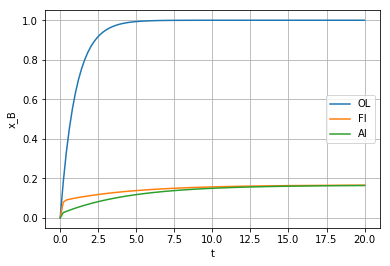

In [12]:
plt.ylabel('x_B')
Plot(t_step,x_ol,x_fi,x_ai)

Text(0,0.5,'v_2')

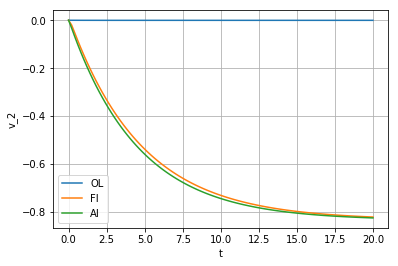

In [13]:
plt.ylabel('v_2')
Plot(t_step,v_ol,v_fi,v_ai)

# Loop-gain analysis

- The product component **Ce:B** is converted into a chemostat. This 'breaks the loop' and enables the open-loop transfer functions relating $x_B$ to the various flows impinging on the corresponding **0** junction to be computed. In this case the relevant flows are:
    - $v_{r2}$ - the main feedback path
    - $v_{r3}$ - the product flow flow absorbed by  **Ce:B0**
    - $5v_{re}$ - the flow transiently absorbed by **Ce:EM**
    - $5v_{ce}$ - the flow transiently absorbed by **Ce:CM**
    
- The function LoopGain 

In [14]:
def LoopGain(abg,chemostats,parameter,x_ss,quiet=False):
    """Compute the loop gain tf"""
    
    ## Add the chemostat for B and recompute stoichiometry
    chemostatsL = chemostats+['B']
    sL,scL = stoichiometry(abg,chemostats=chemostatsL)
    
    ## Linearise using the appropriate steady-state x_ss
    SysL = st.lin(sL,scL,x_ss=x_ss,parameter=parameter,outvar='V',quiet=quiet)
    
    ## The multivariable transfer function
    TFL = con.ss2tf(SysL)
    

    ## Stoichiometry of feedback
    N = sL['N'] # Stoichiometric matrix
    i_B = sL['species'].index('B')
    N_B = N[i_B,:] # Row of N corresponding to B
    
    ## Indices of reactions impinging on Ce:
    j_FB = np.nonzero(N_B)[0][:]
    
    ## Reactions impinging on B and the transfer functions
    reaction = sL['reaction']
    R = []
    FB = {}
    fb = 0
    for j in j_FB:
        r = reaction[j]
        R.append(r)
        FB[r] = extractTFflow(TFL,'B',chemostatsL,r)
        fb = con.parallel(fb,-N_B[j]*FB[r])
    print('\nRelevant reactions:', R)
    
    ## Total feedback transfer function 
    print('Net feedback')
    fb = con.minreal(fb,tol=tol)    
    showTF(fb)
    
    ## Transfer function of CE:B
    G = con.tf([K_B],[1,0])
    print("Forward gain to B")
    showTF(G)
    
    print('Loop gain L')
    L = con.series(G,fb)
    print(L)
    
    print("Closed loop")
    LL = con.minreal(con.feedback(G,sys2=fb),tol=tol)
    showTF(LL)
    
    ## Plot Bode diagram
    print('Bode diagram')
    w = np.logspace(-1,3)
    mag,phase,ww = con.freqresp(L,w)
    plt.loglog(w,mag[0,0])
    plt.xlabel('$\omega$ (rad/sec)')
    plt.ylabel('$|L|$')
    plt.grid()
    plt.show()
    plt.semilogx(w,phase[0,0]*180/np.pi)
    plt.xlabel('$\omega$ (rad/sec)')
    plt.ylabel('arg $L$ (deg)')
    plt.grid()
    plt.show()

## Open-loop system
Setting $\kappa_{re} = \kappa_{rc} = \kappa_{ra} = 0$ prevents flow through the inhibition system and thus feedback is prevented. The system is open-loop.

- The only non-zero feedback path is via $v_{r3}$. 
- The closed-loop system derived from $L$ is the same as given above.

Open loop

Transfer function from x_B to v_r2
0 states have been removed from the model

-0.0003921 s - 0.0396
---------------------
       s + 102

	gain: -0.000
	poles: [-102.02]
	zeros: [-101.]

Transfer function from x_B to v_r3
1 states have been removed from the model

1
-
1

	gain: 1.000
	poles: []
	zeros: []

Transfer function from x_B to v_rc
0 states have been removed from the model

0
-
1

	gain: 0.000
	poles: []
	zeros: []

Transfer function from x_B to v_re
0 states have been removed from the model

0
-
1

	gain: 0.000
	poles: []
	zeros: []

Relevant reactions: ['r2', 'r3', 'rc', 're']
Net feedback
1 states have been removed from the model

1
-
1

	gain: 1.000
	poles: []
	zeros: []
Forward gain to B

1
-
s

	gain:   inf
	poles: [0.]
	zeros: []
Loop gain L

1
-
s

Closed loop
0 states have been removed from the model

  1
-----
s + 1

	gain: 1.000
	poles: [-1.]
	zeros: []
Bode diagram


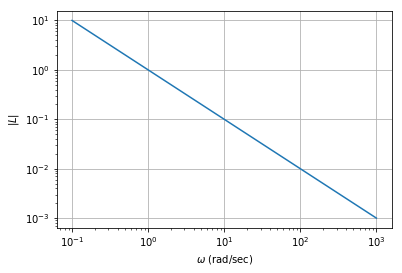

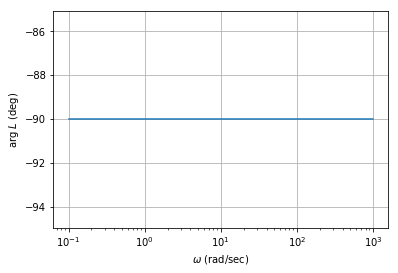

In [15]:
## Open loop
print('Open loop')
parameter['kappa_re'] = 0
parameter['kappa_rc'] = 0
parameter['kappa_ra'] = 0

LoopGain(abg,chemostats,parameter,x_ss_ol,quiet=quiet)

## Feedback inhibition
Setting $\kappa_{rc} = \kappa_{ra} = 0$ and $\kappa_{re}=1$ restricts feedback to the path through re and is thus equivalent to feedback inhibition.
- In addition to the  non-zero feedback path is via $v_{r3}$, the feedback paths through $v_{r2}$ (the main feedback path) and via $v_{re}$ are non-zero. 
- The main feedback path has a steady-state gain of 5.
- The steady-state gain via $v_{re}$ is zero - the effect of this path is transient.
- The closed-loop system derived from $L$ is the same as given above.

Feedback inhibition

Transfer function from x_B to v_r2
0 states have been removed from the model

-0.0003839 s^2 + 0.001222 s - 260.5
-----------------------------------
       s^2 + 128.1 s + 52.09

	gain: -5.000
	poles: [-127.657   -0.408]
	zeros: [1.592+823.657j 1.592-823.657j]

Transfer function from x_B to v_r3
2 states have been removed from the model

1
-
1

	gain: 1.000
	poles: []
	zeros: []

Transfer function from x_B to v_rc
0 states have been removed from the model

0
-
1

	gain: 0.000
	poles: []
	zeros: []

Transfer function from x_B to v_re
0 states have been removed from the model

-2.605 s^2 - 265.8 s - 1.137e-13
--------------------------------
      s^2 + 128.1 s + 52.09

	gain: -0.000
	poles: [-127.657   -0.408]
	zeros: [-1.020e+02 -4.278e-16]

Relevant reactions: ['r2', 'r3', 'rc', 're']
Net feedback
2 states have been removed from the model

14.03 s^2 + 1457 s + 312.6
--------------------------
  s^2 + 128.1 s + 52.09

	gain: 6.000
	poles: [-127.657   -0.408]
	zero

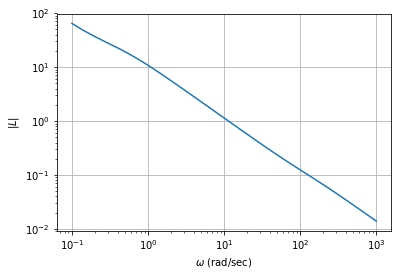

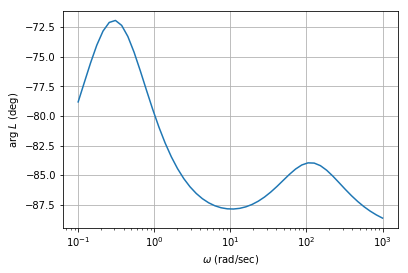

In [16]:
## Feedback inhibition
print('Feedback inhibition')

parameter['kappa_re'] = 1
parameter['kappa_rc'] = 0
parameter['kappa_ra'] = 0

LoopGain(abg,chemostats,parameter,x_ss_fi,quiet=quiet)

##  Allosteric inhibition
Setting $\kappa_{re} =\kappa_{rc} = \kappa_{ra} = 1$ releases all feedback paths.

- All feedback paths are now in use.
- The main feedback path has a steady-state gain of  about 5.
- The steady-state gains via $v_{re}$ and $v_{rc}$ are small - the effect of these paths is transient.
- The closed-loop system derived from $L$ is the same as given above.

Allosteric inhibition

Transfer function from x_B to v_r2
0 states have been removed from the model

-0.0003179 s^2 - 8.734 s - 910.2
--------------------------------
      s^2 + 105.5 s + 180.5

	gain: -5.042
	poles: [-103.751   -1.74 ]
	zeros: [-27366.453   -104.613]

Transfer function from x_B to v_r3
2 states have been removed from the model

1
-
1

	gain: 1.000
	poles: []
	zeros: []

Transfer function from x_B to v_rc
0 states have been removed from the model

8.704 s^2 + 903 s - 12.8
------------------------
  s^2 + 105.5 s + 180.5

	gain: -0.071
	poles: [-103.751   -1.74 ]
	zeros: [-1.038e+02  1.418e-02]

Transfer function from x_B to v_re
0 states have been removed from the model

-0.2476 s^2 - 25.69 s - 12.8
----------------------------
    s^2 + 105.5 s + 180.5

	gain: -0.071
	poles: [-103.751   -1.74 ]
	zeros: [-103.248   -0.501]

Relevant reactions: ['r2', 'r3', 'rc', 're']
Net feedback
5 states have been removed from the model

45.76 s + 10.51
---------------
    s + 1.74


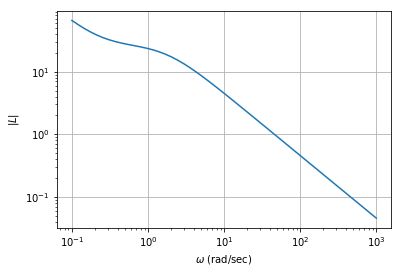

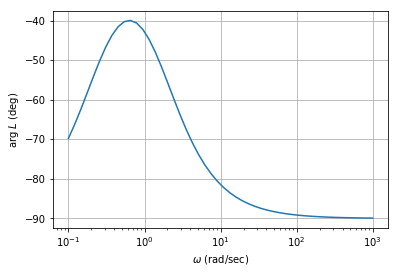

In [17]:
## Allosteric inhibition
print('Allosteric inhibition')

parameter['kappa_re'] = 1
parameter['kappa_rc'] = 1
parameter['kappa_ra'] = 1

LoopGain(abg,chemostats,parameter,x_ss_ai,quiet=quiet)

# Discussion

- A novel approach to determining loop-gains from bond graphs of biomolecular systems is given

- An example, enzyme catalysed reaction with allosteric inhibition, illustrates the approach

- In this simple case, the product $x_B$ and the control signal $v_2$ are collocated; this would not generally be the case.

- Because of the collocation, the phase lag of the loop-gain is less that $90^\circ$ (check this) thus there are no stability issues on closing the loop.

- Systems where the product is at the end of a chain of reactions are more problematic from the control point of view.

- There can be numerical issues with manipulating transfer functions. Minreal (minimum realisation) has been used here with a large tolerance to remove appoximate pole-zero cancellations. Balred (Balanced reduced order model) could also be useful here.

- Setting chemostatEMCM = False in the preamble shows the case where these species are not fixed. 

- it would be interesting to apply this approach to the metabolic model of 
<cite data-cite="CloWel10">Cloutier and Wellstead (2010)</cite>.
